# Logistic Regression


This notebook implements logistic regression, a supervised learning technique for binary classification. This regression algorithm estimates the probability that an instance belongs to a particular class. Specifically, given a set of input features, the logistic regression model produces an estimated probability of belonging to the *positive* class. If this estimated probability is at least 50%, then the instance is predicted to belong to this positive class; otherwise it is predicted to belong to the *negative* class.

---

First, load the relevant libraries needed.

In [98]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import a nice function for plotting decision boundaries
from mlxtend.plotting import plot_decision_regions

# Set the Seaborn theme
sns.set_theme()

# Import functions from scikit-learn to help with training/testing endeavors
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## The Data

A logistic regression model will be trained using the [Hawks](https://r-data.pmagunia.com/dataset/r-dataset-package-stat2data-hawks) dataset. This dataset contains observations for three species of hawks, and attributes such as age, sex, wing length, body weight, tail length, etc. 

The code block below reads the dataset into a pandas DataFrame object, subsets the DataFrame to the relevant variables, and drops any rows where there are missing values for these relevant variables.

In [2]:
# Read in the data and subset it to the relevant columns/observations
hawks = pd.read_csv("../../Data/hawks.csv")
hawks = hawks[["Species", "Wing", "Tail", "Weight", "Culmen", "Hallux"]].dropna(axis=0)
hawks

,Species,Wing,Tail,Weight,Culmen,Hallux
0,RT,385.0,219,920.0,25.7,30.1
2,RT,381.0,235,990.0,26.7,31.3
3,CH,265.0,220,470.0,18.7,23.5
4,SS,205.0,157,170.0,12.5,14.3
5,RT,412.0,230,1090.0,28.5,32.2
...,...,...,...,...,...,...
903,RT,380.0,224,1525.0,26.0,27.6
904,SS,190.0,150,175.0,12.7,15.4
905,RT,360.0,211,790.0,21.9,27.6
906,RT,369.0,207,860.0,25.2,28.0


### Preparing the data
Observe that the `Species` is a variable consisting of 3 categories:

1. `RT`: Red-tailed
2. `CH`: Cooper's
3. `SS`: Sharp-Shinned

Logistic regression is a binary classification method, so we will have to collapse these categories. From `hawks_analysis.ipynb` ([link](https://github.com/kary5678/INDE-577/blob/main/Data/hawks_analysis.ipynb)), I observe that the Cooper's and sharp-shinned hawks are clustered relatively near each other.  Furthermore, there are disproportionate counts of each species in the dataset; there are far more red-tailed hawks. Therefore, I will combined the Cooper's and sharp-shinned hawks into a single "not red-tailed" group. The classification task will then be to identify if a hawk is red-tailed or not red-tailed, given it's wing length and tail length. As there is a clear clustering for each group based on their wing and tail lengths, classification is a viable goal. 

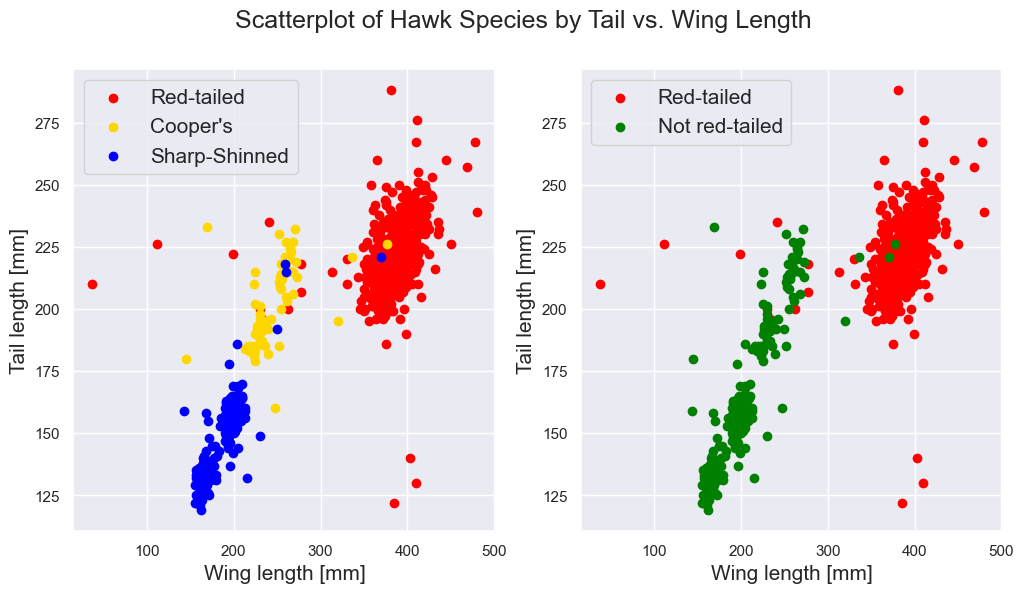

In [3]:
# Produce a scatterplot of tail vs. wing length, color-coded by hawk species
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle("Scatterplot of Hawk Species by Tail vs. Wing Length", fontsize = 18)
# First, plot the 3 different species' distribution on the left
RT = hawks[hawks.Species == "RT"]
CH = hawks[hawks.Species == "CH"]
SS = hawks[hawks.Species == "SS"]
ax1.scatter(RT.Wing, RT.Tail, color = "red", label = "Red-tailed")
ax1.scatter(CH.Wing, CH.Tail, color = "gold", label = "Cooper's")
ax1.scatter(SS.Wing, SS.Tail, color = "blue", label = "Sharp-Shinned")
ax1.set_xlabel("Wing length [mm]", fontsize = 15)
ax1.set_ylabel("Tail length [mm]", fontsize = 15)
ax1.legend(fontsize = 15, loc = "upper left")

# Plot the binary red-tailed vs. not red-tailed distribution on the right
NRT = hawks[hawks.Species != "RT"]
ax2.scatter(RT.Wing, RT.Tail, color = "red", label = "Red-tailed")
ax2.scatter(NRT.Wing, NRT.Tail, color = "green", label = "Not red-tailed")
ax2.set_xlabel("Wing length [mm]", fontsize = 15)
ax2.set_ylabel("Tail length [mm]", fontsize = 15)
ax2.legend(fontsize = 15, loc = "upper left")
plt.show()

## Implementing the algorithm: a custom class

In [108]:
class LogisticRegression(object):
    """
    A class to perform logistic regression.
    ...

    Attributes
    ----------
    weights_ : numpy.ndarray
        The weights and bias of the single neuron. The last entry being the bias. 
        This attribute is created when the train method is called.

    train_errors_: list
        A list containing error computed after each iteration of stochastic gradient descent.
 
    """

    def __init__(self):
        self.weights_ = None
        self.train_errors_ = []

    def train(self, X, y, rate = 0.005, iterations = 50):
        """
        Train a logistic regression model by iterating through the stochastic gradient descent 
        algorithm. This occurs for a total of "epochs" number of times with learning rate "rate".

        Parameters
        ----------
        X: matrix of feature values
        y: array of observed values
        rate (float): learning rate
        iterations (int): number of iterations to train the model for

        Returns: None
        """
        n_obs, n_features = X.shape
        self.train_errors_ = []

        # Initialize coefficients/weights and intercept/bias from a uniform distribution
        self.weights_ = np.random.rand(1 + n_features)
        
        # Implement stochastic gradient decent  
        for _ in range(iterations):
            errors = 0
            for xi, target in zip(X, y):
                error = (self.predict(xi) - target)
                self.weights_[:-1] -= rate * error * xi
                self.weights_[-1] -= rate * error
                errors += self.entropy_loss(self.predict_prob(xi), target)
            self.train_errors_.append(errors / n_obs)


    def sigmoid(self, z):
        """
        Implements the sigmoid function
        """
        return 1 / (1 + np.exp(-z))
    
    def entropy_loss(self, y_hat, y):
        return - y*np.log(y_hat) - (1 - y)*np.log(1 - y_hat)

    def predict_prob(self, X):
        """
        Use the weights and the feature vectors in X to make a prediction. This prediction
        is actually the probability that the observation belongs to the positive class. 
        """
        preactivation = np.dot(X, self.weights_[:-1]) + self.weights_[-1]
        return self.sigmoid(preactivation)

    def predict(self, X):
        """
        Given the feature vectors in X, make a prediction as to whether the observation
        belongs to the positive class or not.
        """
        return np.where(self.predict_prob(X) >= 0.5, 1, 0)

    def plot_cost_function(self):
        plt.figure(figsize = (7, 5))
        plt.plot(range(1, len(self.train_errors_) + 1), self.train_errors_)
        plt.xlabel("Iterations")
        plt.ylabel("Entropy Loss")
        plt.title("Binary Cross Entropy Loss for Trained Logistic Regression Model")

    def plot_decision_boundary(self, X, y, x_title = "x", y_title = "y"):
        plt.figure(figsize = (7, 5))
        plot_decision_regions(X, y, clf = self)
        plt.title("Logistic Regression Decision Boundary", fontsize = 14)
        plt.xlabel(x_title, fontsize = 12)
        plt.ylabel(y_title, fontsize = 12)
        plt.show()

## Model 1: Binary Classification Using 1 Predictor (Tail Length)

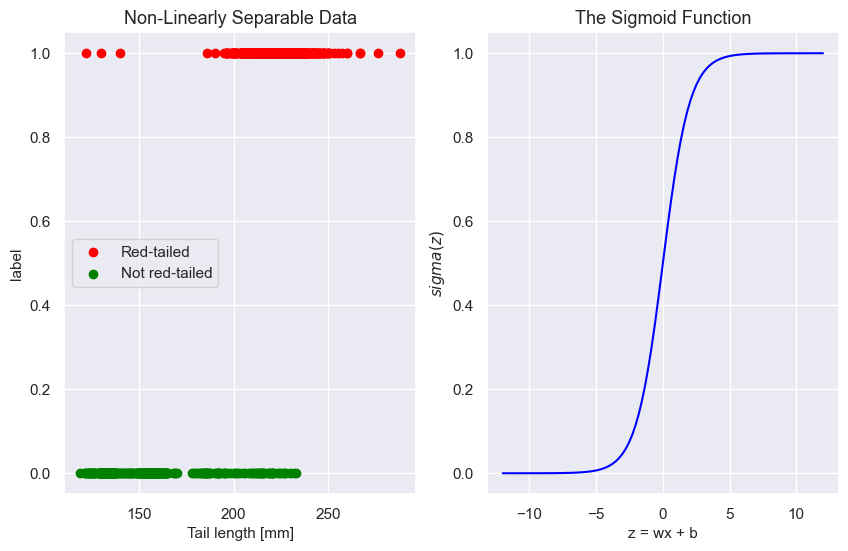

In [119]:
def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))

domain = np.linspace(-12.0, 12.0, 100)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
#ax1.set_xlim((2.75, 7))
ax1.scatter(RT.Tail, 
            np.ones(len(RT.Tail)), 
            color = "red", 
            label = "Red-tailed")
ax1.scatter(NRT.Tail, 
            np.zeros(len(NRT.Tail)), 
            color = "green", 
            label = "Not red-tailed")
ax1.set_xlabel("Tail length [mm]", fontsize = 11)
ax1.set_ylabel("label", fontsize = 11)
ax1.set_title("Non-Linearly Separable Data", fontsize = 13)
ax1.legend(fontsize = 11, loc = "center left")

ax2.plot(domain, 
        sigmoid(domain), 
        color = "blue", 
        label = "$\sigma$(z)")
ax2.set_xlabel("z = wx + b", fontsize = 11)
ax2.set_ylabel("$sigma(z)$", fontsize = 11)
ax2.set_title("The Sigmoid Function", fontsize = 13)
plt.show()

The processed data is randomly split into a training and testing set using the traditional 80-20 rule of the Pareto Principle. The parameter `random_state=1` is used to ensure that we get the same observations in the training/testing set as in the Hawks exploratory analysis notebook [here](https://github.com/kary5678/INDE-577/blob/main/Data/hawks_analysis.ipynb). We know from the plots in `hawks_analysis.ipynb` that the split using this `random_state` produces a training set that is a good representation for the data being tested (and vice versa).

In [ ]:
# Set up predictors matrix (X) and response vector (y)
#X = hawks[["Wing", "Tail"]].to_numpy()
X = hawks[["Tail"]].to_numpy()
# Convert each entry of y with RT (red-tailed) to -1 and otherwise 1
hawks["Species_binary"] = [1 if x == "RT" else 0 for x in hawks.Species]
y = hawks["Species_binary"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [109]:
# Train the logistic regression model
lr_model = LogisticRegression()
lr_model.train(X_train, y_train, 0.0001, 5000)

/var/folders/vw/11tt08k53x3ftj1j70zwt66c0000gn/T/ipykernel_1584/609802888.py:78: RuntimeWarning: divide by zero encountered in log
  return - y*np.log(y_hat) - (1 - y)*np.log(1 - y_hat)
/var/folders/vw/11tt08k53x3ftj1j70zwt66c0000gn/T/ipykernel_1584/609802888.py:78: RuntimeWarning: invalid value encountered in multiply
  return - y*np.log(y_hat) - (1 - y)*np.log(1 - y_hat)


In [110]:
lr_model.weights_

array([ 0.03786125, -6.69022004])

### Performance/error analysis for model 1

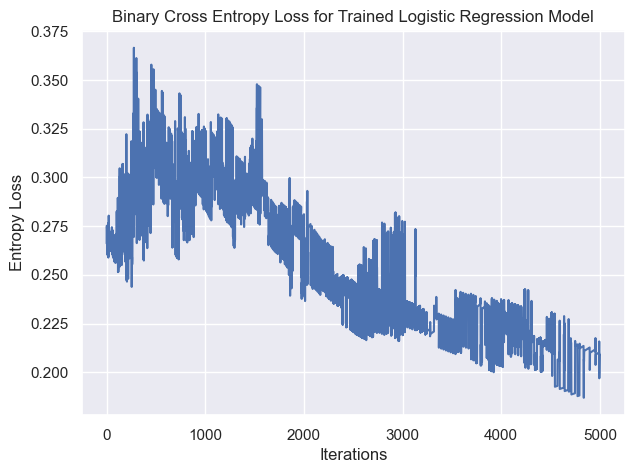

In [111]:
lr_model.plot_cost_function()
plt.show()

In [112]:
# Obtain predictions for training set and find the error of the model
y_train_pred = lr_model.predict(X_train)
print("Training accuracy:", sum(y_train == y_train_pred) / len(y_train))

Training accuracy: 0.9143258426966292


In [113]:
# Obtain predictions for testing set and find the test accuracy
y_test_pred = lr_model.predict(X_test)
print("Testing accuracy:", sum(y_test == y_test_pred) / len(y_test))

Testing accuracy: 0.9217877094972067


In [114]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.81      0.89        73
           1       0.88      1.00      0.94       106

    accuracy                           0.92       179
   macro avg       0.94      0.90      0.92       179
weighted avg       0.93      0.92      0.92       179



In [115]:
def plot_RT_confusion_matrix(y_actual, y_pred):
    """
    Plots the confusion matrix given the actual and predicted values
    to easily view accurate classifications and type I/II errors
    """             
    classes = [1, 0] # want to invert the order of the classes in outputted matrix
    # Obtain confusion matrix
    cf_matrix = confusion_matrix(y_actual, y_pred, labels=[1, 0])

    # View the confusion matrix using the seaborn package
    plt.figure(figsize = (6, 4))
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
    ax.set_title('Hawk Species Classification Confusion Matrix\n', fontsize = 14)
    ax.set_xlabel('\nPredicted Values', fontsize = 12)
    ax.set_ylabel('Actual Values ', fontsize = 12)
    ax.xaxis.set_ticklabels(["RT", "Not RT"])
    ax.yaxis.set_ticklabels(["RT", "Not RT"])

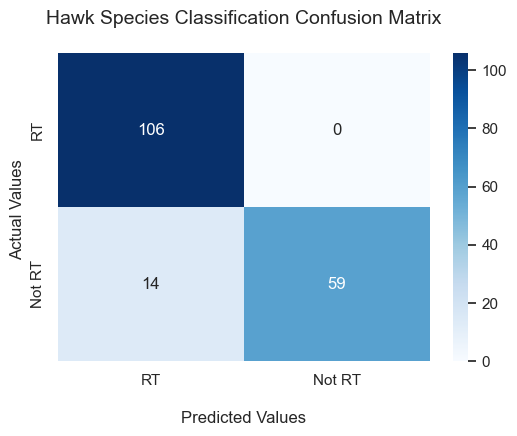

In [116]:
plot_RT_confusion_matrix(y_test, y_test_pred)
plt.show()

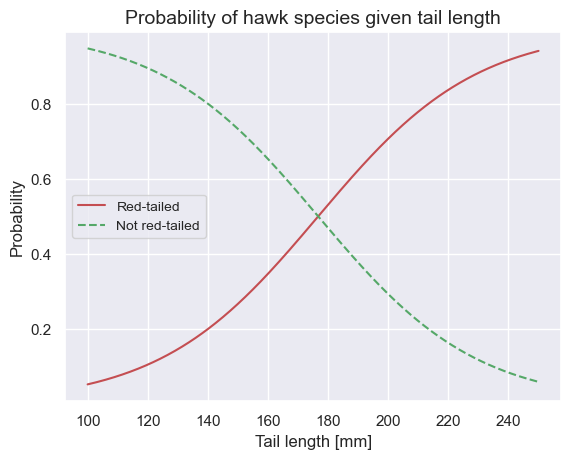

In [117]:
# Plot estimated probabilities to find decision boundary
X_new = np.linspace(100, 250, 1000).reshape(-1, 1)
y_prob = lr_model.predict_prob(X_new)
plt.plot(X_new, y_prob, "r-", label="Red-tailed") 
plt.plot(X_new, 1 - y_prob, "g--", label="Not red-tailed")
plt.legend(fontsize = 10, loc = "center left")
plt.xlabel("Tail length [mm]", fontsize = 12)
plt.ylabel("Probability", fontsize = 12)
plt.title("Probability of hawk species given tail length", fontsize = 14)
plt.show()

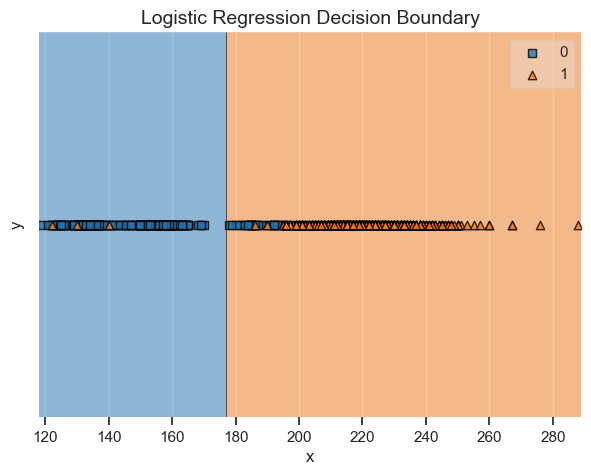

In [118]:
lr_model.plot_decision_boundary(X, y)

## Model 2: Binary Classification Using 2 Predictors (Wing & Tail Length)

## Using scikit-learn

In [82]:
from sklearn.linear_model import LogisticRegression as skLogisticRegression

log_reg = skLogisticRegression()
log_reg.fit(X_train, y_train)
log_reg.intercept_, log_reg.coef_

(array([-19.21080332]), array([[0.09981994]]))

In [22]:
log_reg.score(X_train, y_train)

0.9452247191011236

In [23]:
log_reg.score(X_test, y_test)

0.9385474860335196

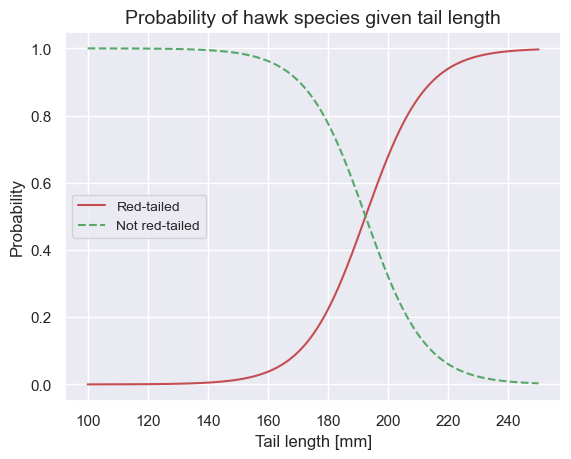

In [27]:
# Plot estimated probabilities to find decision boundary
X_new = np.linspace(100, 250, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], "r-", label="Red-tailed") 
plt.plot(X_new, y_proba[:, 0], "g--", label="Not red-tailed")
plt.legend(fontsize = 10, loc = "center left")
plt.xlabel("Tail length [mm]", fontsize = 12)
plt.ylabel("Probability", fontsize = 12)
plt.title("Probability of hawk species given tail length", fontsize = 14)
plt.show()

In [25]:
# Predict a hawk's classification given their tail length is 160 mm
log_reg.predict(np.array([160]).reshape(-1, 1))

array([-1])

In [26]:
# Predict a hawk's classification given their tail length is 220 mm
log_reg.predict(np.array([220]).reshape(-1, 1))

array([1])